## Node classification (data : karateclub)

In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx, to_undirected
import networkx as nx

import matplotlib.pyplot as plt

### Model

In [2]:
class GCN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_features, hidden_features)
        self.conv2 = GCNConv(hidden_features, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        out = F.log_softmax(x,1) 
        return x, out

In [3]:
def load_data(path, node_feat):
    f = open("links.txt", 'r')
    lines = f.readlines()
    sn, tn = [], [] 
    # to make edge_index format. tensor_shape : [2, num_edges]
    for line in lines:
        s, t = line.split(",")
        sn.append(int(s))
        tn.append(int(t))
    edge_index = torch.tensor([sn, tn], dtype=torch.long)
    # node_feature matrix format; tensor_shape : [num_nodes, num_node_features]
    data = Data(x=node_feat, edge_index=edge_index)
    
    f.close()
    return data
    

### Load data

In [4]:
# we have no node_features. only node_index.. 
x = torch.eye(34) # #node=34 
data = load_data("links.txt", x)

### Train

In [5]:
labeled_nodes = torch.tensor([0,33])
labels = torch.tensor([0,1])

emb_log = []
model = GCN(34,16,2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
model.train()

for epoch in range(10):
    optimizer.zero_grad()
    emb, pred = model(data)
    emb_log.append(emb.detach())
    
    loss = F.nll_loss(pred[labeled_nodes], labels)
    loss.backward()
    optimizer.step()
    print('Epoch %d / Loss : %.4f' %(epoch, loss.item()))

Epoch 0 / Loss : 0.7207
Epoch 1 / Loss : 0.4337
Epoch 2 / Loss : 0.3064
Epoch 3 / Loss : 0.1705
Epoch 4 / Loss : 0.0929
Epoch 5 / Loss : 0.0432
Epoch 6 / Loss : 0.0178
Epoch 7 / Loss : 0.0069
Epoch 8 / Loss : 0.0027
Epoch 9 / Loss : 0.0010


In [6]:
model.eval()
embedding, prediction = model(data)
prediction = pred.argmax(1)
print("prediction", prediction)

prediction tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [7]:
def plot_graph(data, node_labels=None):
    fig, ax = plt.subplots()
    fig.set_tight_layout(False)
    nx_g = to_networkx(data=data).to_undirected()
    pos = nx.kamada_kawai_layout(nx_g)
    
    if node_labels is not None:
        node_color = [[1, 1, 0.5] if x else [1,0.5,0.5] for x in node_labels]
   
    nx.draw(nx_g, pos, with_labels=True, node_size = 200, node_color = node_color, font_size = 8)
    
    plt.show()

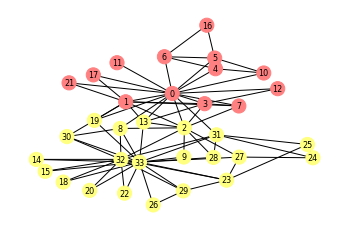

In [8]:
plot_graph(data, prediction)